<a href="https://colab.research.google.com/github/viniiciusBsilva/ProjetoDePesquisa_BaseDeDados_PetsHI/blob/main/21_01_2025_Copy_of_k%3D_10_Kfold_vgg16_PetsHI(BreaKHis_weights).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KFold-VGG16-PetsHI(BreasKHist weights)

---



Instituto Federal de Educação, Ciência e Tecnologia do Maranhão.

Aluno: Vinícius Barbosa Da Silva

Matrícula: 20181SI0007

Orientador: Omar Andres Carmona Cortes

Projeto: Uma Base de Dados para Identificação de Câncer em PETs Usando Aprendizagem Profunda

---



O conjunto de dados possui 592 imagens totais divididas em benign(mama normal) = 220 e malignant(neoplasia) = 372. o conjunto foi aumentado em 10x as imagens de benign e 5x as imagens de malignant com as transformações: flip vertical, flip horizontal e random crop(0, 100).

Neste Notebook foi feito o 2 Kfold no modelo VGG16, um sem pesos pré-treinados BreakHis, outro com pesos pré-treinados do BreasKHis. Na utilização do modelo pré treinado BreakHis há um double transfer learning no qual a VGG16 usa pesos do imagenet e depois do BreasKHis com ajuste fino para congelar camadas. Com K = 5.



---



## Import das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.backend import clear_session

import sklearn
from sklearn.model_selection import KFold, train_test_split


import pathlib
import os

## Extraindo PATH e LABELS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path = '/content/drive/MyDrive/Base de dados de HI Pets.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
data_path = pathlib.Path(r'/content/Base de dados de HI Pets')

# glob all 'jpg' image files
img_path = list(data_path.glob('**/*.jpg'))

# split label names do diretório
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [ ]:
# Criar um DataFrame
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)
img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

# Amostras aleatórias
img_df = img_df.sample(frac=1).reset_index(drop=True)

# Mostrar as primeiras linhas do DataFrame após a transformação
img_df.head()

,PATH,LABELS
0,/content/Base de dados de HI Pets/malignant/cl...,malignant
1,/content/Base de dados de HI Pets/malignant/cl...,malignant
2,/content/Base de dados de HI Pets/benign/class...,benign
3,/content/Base de dados de HI Pets/benign/class...,benign
4,/content/Base de dados de HI Pets/benign/class...,benign


In [ ]:
img_df['LABELS'].value_counts(ascending=True)


,count
LABELS,
benign,220
malignant,372


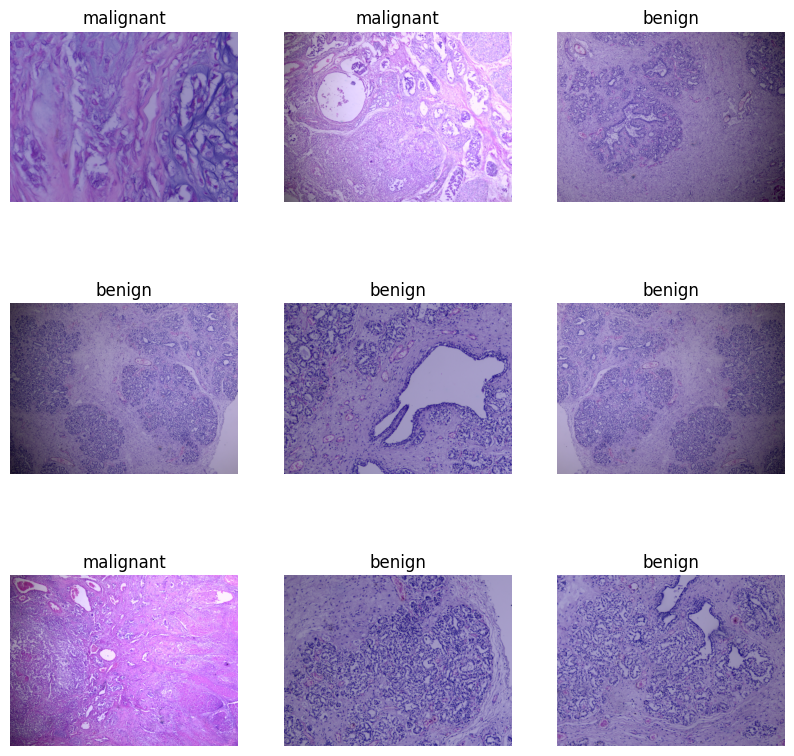

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img_df.PATH[i]))
  plt.title(img_df.LABELS[i])
  plt.axis("off")

## Dividindo em Teste e Treino

In [ ]:
train_dataset, test_dataset = train_test_split(img_df, train_size=0.8, shuffle=True, stratify=img_df['LABELS'], random_state=1)
print("Number of train data:", train_dataset.shape[0])
print("Number of test data:", test_dataset.shape[0])

Number of train data: 473
Number of test data: 119


In [ ]:
train_dataset

,PATH,LABELS
543,/content/Base de dados de HI Pets/malignant/cl...,malignant
532,/content/Base de dados de HI Pets/malignant/cl...,malignant
98,/content/Base de dados de HI Pets/benign/class...,benign
389,/content/Base de dados de HI Pets/benign/class...,benign
94,/content/Base de dados de HI Pets/benign/class...,benign
...,...,...
180,/content/Base de dados de HI Pets/malignant/cl...,malignant
454,/content/Base de dados de HI Pets/malignant/cl...,malignant
217,/content/Base de dados de HI Pets/malignant/cl...,malignant
105,/content/Base de dados de HI Pets/benign/class...,benign


## Data Augmentation

In [ ]:

width = 224
height = 224
batch_size = 32

gerador_treinamento = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


## Teste

In [ ]:
test_gen = ImageDataGenerator(rescale=1/255.0)
test_ds = test_gen.flow_from_dataframe(test_dataset,
                                       x_col='PATH', y_col='LABELS',
                                       target_size=(224,224),
                                       class_mode = 'binary',
                                       color_mode = 'rgb',
                                       batch_size = 16,
                                       shuffle=False)

Found 119 validated image filenames belonging to 2 classes.


## Funções de métricas

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(histories, test_ds):
    # Para cada fold
    for fold, history in enumerate(histories, start=1):
        print(f"Fold {fold}:")

        # Prever as classes no conjunto de teste
        test_predictions = history.model.predict(test_ds)

        test_predictions_binary = (test_predictions > 0.5).astype(int)

        y_test = test_ds.labels

        accuracy = accuracy_score(y_test, test_predictions_binary)
        print(f"Accuracy: {accuracy:.2f}")

        class_names = list(test_ds.class_indices.keys())

        report = classification_report(y_test, test_predictions_binary, target_names=class_names)
        print("Classification Report:\n", report)


        confusion = confusion_matrix(y_test, test_predictions_binary)

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        print("\n")


In [ ]:
import scipy
print(scipy.__version__)

1.13.1


Plot da curva ROC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

def plot_roc_curves(histories, test_ds):
    fig1 = plt.figure(figsize=[6, 6])
    ax1 = fig1.add_subplot(111, aspect='equal')


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, history in enumerate(histories):
        test_predictions = history.model.predict(test_ds)

        fpr, tpr, _ = roc_curve(test_ds.labels, test_predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.5, label='ROC fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % mean_auc, lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

## Sem Pesos BreakHis

### Model VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_model():
    # Carregar modelo pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelar as camadas do modelo pré-treinado
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))


    # Compilar o modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    return model


### Kfold

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import files
EPOCHS = 10
histories_model_imagenet = []

kfold = KFold(10, shuffle=True, random_state=123)

for f, (trn_ind, val_ind) in enumerate(kfold.split(train_dataset)):

    print();
    print("#"*50)
    print("Fold: ",f+1)
    print("#"*50)

    training_data = train_dataset.iloc[trn_ind]
    validation_data = train_dataset.iloc[val_ind]

    train_ds = gerador_treinamento.flow_from_dataframe(training_data,
                                            x_col='PATH', y_col='LABELS',
                                            target_size=(width,height),
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = 32, shuffle = True)
    val_ds = gerador_treinamento.flow_from_dataframe(validation_data,
                                        x_col='PATH', y_col='LABELS',
                                        target_size=(width,height),
                                        class_mode = 'binary', color_mode = 'rgb',
                                        batch_size = 32, shuffle = False)


    model1 = create_model()


    # Treinar o modelo
    history = model1.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // batch_size,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=val_ds.samples // batch_size
    )

    # store history pra cada folds
    histories_model_imagenet.append(history)

    clear_session()



##################################################
Fold:  1
##################################################
Found 425 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6100 - auc_2: 0.6577 - loss: 1.3366 - precision_2: 0.7035 - recall_2: 0.6482 - val_accuracy: 0.8125 - val_auc_2: 0.9187 - val_loss: 0.3926 - val_precision_2: 0.9375 - val_recall_2: 0.7500
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6875 - auc_2: 0.7733 - loss: 1.2709 - precision_2: 0.6957 - recall_2: 0.8421

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 726ms/step - accuracy: 0.6875 - auc_2: 0.7733 - loss: 1.2709 - precision_2: 0.6957 - recall_2: 0.8421 - val_accuracy: 0.9375 - val_auc_2: 0.9921 - val_loss: 0.3876 - val_precision_2: 1.0000 - val_recall_2: 0.8889
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 781ms/step - accuracy: 0.7852 - auc_2: 0.8653 - loss: 0.9312 - precision_2: 0.8165 - recall_2: 0.8268
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.7500 - auc_2: 0.8727 - loss: 1.1283 - precision_2: 0.7333 - recall_2: 1.0000 - val_accuracy: 0.5938 - val_auc_2: 0.8583 - val_loss: 0.9753 - val_precision_2: 0.6129 - val_recall_2: 0.9500
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 870ms/step - accuracy: 0.8723 - auc_2: 0.8919 - loss: 0.6410 - precision_2: 0.9162 - recall_2: 0.8879 - val_accuracy: 0.9375 - val_auc_2: 0.9841 - val_loss: 0.2332 - val_precision_2: 0.9000 - val_recall_2: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - auc_2: 0.9565 - loss: 0.2810 - pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6778 - auc: 0.6859 - loss: 1.5440 - precision: 0.7109 - recall: 0.6797 - val_accuracy: 0.6875 - val_auc: 0.7979 - val_loss: 1.0411 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6875 - auc: 0.8073 - loss: 2.6660 - precision: 1.0000 - recall: 0.5833

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6875 - auc: 0.8073 - loss: 2.6660 - precision: 1.0000 - recall: 0.5833 - val_accuracy: 0.7500 - val_auc: 0.8909 - val_loss: 0.8500 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 832ms/step - accuracy: 0.7825 - auc: 0.8269 - loss: 1.2696 - precision: 0.8155 - recall: 0.8386
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8750 - auc: 0.9167 - loss: 0.6344 - precision: 0.8636 - recall: 0.9500 - val_accuracy: 0.6875 - val_auc: 0.9125 - val_loss: 0.8270 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 732ms/step - accuracy: 0.8267 - auc: 0.8924 - loss: 0.8140 - precision: 0.8356 - recall: 0.8999 - val_accuracy: 0.9375 - val_auc: 0.9818 - val_loss: 0.1373 - val_precision: 0.9167 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7500 - auc: 0.8164 - loss: 2.1035 - precision: 0.6667 - recall: 1.0000  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5932 - auc: 0.6343 - loss: 1.7220 - precision: 0.6602 - recall: 0.6507 - val_accuracy: 0.8750 - val_auc: 0.9514 - val_loss: 0.2733 - val_precision: 0.8947 - val_recall: 0.8947
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7188 - auc: 0.8913 - loss: 1.3245 - precision: 1.0000 - recall: 0.6087

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7188 - auc: 0.8913 - loss: 1.3245 - precision: 1.0000 - recall: 0.6087 - val_accuracy: 0.7500 - val_auc: 0.9455 - val_loss: 0.3147 - val_precision: 0.7692 - val_recall: 0.9091
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7928 - auc: 0.8470 - loss: 0.9577 - precision: 0.8505 - recall: 0.8156  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.6875 - auc: 0.7540 - loss: 1.9449 - precision: 0.8333 - recall: 0.5556 - val_accuracy: 0.8125 - val_auc: 0.9089 - val_loss: 0.4203 - val_precision: 0.8095 - val_recall: 0.8947
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 834ms/step - accuracy: 0.8357 - auc: 0.9108 - loss: 0.6347 - precision: 0.8825 - recall: 0.8701 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1687 - val_precision: 0.9167 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0954 - precision: 1.0000 - recall: 0.9444  
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6371 - auc: 0.6839 - loss: 1.3727 - precision: 0.6994 - recall: 0.7620 - val_accuracy: 0.6875 - val_auc: 0.7879 - val_loss: 0.7739 - val_precision: 0.6897 - val_recall: 0.9524
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7188 - auc: 0.7500 - loss: 1.2397 - precision: 0.8095 - recall: 0.7727

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 822ms/step - accuracy: 0.7188 - auc: 0.7500 - loss: 1.2397 - precision: 0.8095 - recall: 0.7727 - val_accuracy: 0.7333 - val_auc: 0.7614 - val_loss: 0.5720 - val_precision: 0.7692 - val_recall: 0.9091
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 812ms/step - accuracy: 0.7716 - auc: 0.8269 - loss: 1.0655 - precision: 0.8327 - recall: 0.8162
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9062 - auc: 0.9492 - loss: 0.5306 - precision: 0.8421 - recall: 1.0000 - val_accuracy: 0.7188 - val_auc: 0.8485 - val_loss: 0.6468 - val_precision: 0.7500 - val_recall: 0.8571
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 835ms/step - accuracy: 0.8462 - auc: 0.9026 - loss: 0.8202 - precision: 0.8738 - recall: 0.8579 - val_accuracy: 0.8667 - val_auc: 0.9545 - val_loss: 0.2405 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8750 - auc: 0.9841 - loss: 0.3894 - precision: 0.8182 - recall: 1.0000  
Epoch 7/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6846 - auc: 0.7143 - loss: 1.2591 - precision: 0.7512 - recall: 0.7632 - val_accuracy: 0.5938 - val_auc: 0.9615 - val_loss: 1.2991 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7812 - auc: 0.8097 - loss: 1.5362 - precision: 0.8333 - recall: 0.7895

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7812 - auc: 0.8097 - loss: 1.5362 - precision: 0.8333 - recall: 0.7895 - val_accuracy: 0.6000 - val_auc: 0.9907 - val_loss: 1.1178 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 921ms/step - accuracy: 0.8366 - auc: 0.8781 - loss: 0.9540 - precision: 0.8555 - recall: 0.8978
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8750 - auc: 0.9292 - loss: 0.6783 - precision: 0.9000 - recall: 0.9000 - val_accuracy: 0.7188 - val_auc: 0.8279 - val_loss: 1.1241 - val_precision: 0.6786 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 789ms/step - accuracy: 0.8779 - auc: 0.9283 - loss: 0.5170 - precision: 0.8964 - recall: 0.9129 - val_accuracy: 0.8667 - val_auc: 1.0000 - val_loss: 0.5698 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - auc: 0.8854 - loss: 1.1221 - precision: 0.9444 - recall: 0.7083  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6756 - auc: 0.6833 - loss: 1.5318 - precision: 0.7650 - recall: 0.7430 - val_accuracy: 0.7188 - val_auc: 0.9563 - val_loss: 0.3805 - val_precision: 0.7037 - val_recall: 0.9500
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7812 - auc: 0.8875 - loss: 1.0186 - precision: 0.6667 - recall: 0.8333

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7812 - auc: 0.8875 - loss: 1.0186 - precision: 0.6667 - recall: 0.8333 - val_accuracy: 0.7333 - val_auc: 0.7727 - val_loss: 0.4339 - val_precision: 0.8889 - val_recall: 0.7273
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 813ms/step - accuracy: 0.7561 - auc: 0.8176 - loss: 0.9910 - precision: 0.8119 - recall: 0.7918
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8125 - auc: 0.9177 - loss: 0.6141 - precision: 0.8947 - recall: 0.8095 - val_accuracy: 0.8438 - val_auc: 1.0000 - val_loss: 0.2843 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 842ms/step - accuracy: 0.8958 - auc: 0.9270 - loss: 0.4721 - precision: 0.9101 - recall: 0.9277 - val_accuracy: 0.8667 - val_auc: 0.9545 - val_loss: 0.2502 - val_precision: 0.8462 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9375 - auc: 0.9879 - loss: 0.1275 - precision: 0.9474 - recall: 0.9474  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6041 - auc: 0.6030 - loss: 1.8924 - precision: 0.7113 - recall: 0.6292 - val_accuracy: 0.7812 - val_auc: 0.8866 - val_loss: 0.6272 - val_precision: 0.7500 - val_recall: 0.9474
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7500 - auc: 0.8333 - loss: 1.0941 - precision: 0.9333 - recall: 0.6667

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7500 - auc: 0.8333 - loss: 1.0941 - precision: 0.9333 - recall: 0.6667 - val_accuracy: 0.5333 - val_auc: 0.6696 - val_loss: 0.8692 - val_precision: 0.5455 - val_recall: 0.7500
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7967 - auc: 0.8526 - loss: 0.7243 - precision: 0.8169 - recall: 0.8772  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8125 - auc: 0.9091 - loss: 0.6479 - precision: 0.9444 - recall: 0.7727 - val_accuracy: 0.6562 - val_auc: 0.9211 - val_loss: 0.9033 - val_precision: 0.6333 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 827ms/step - accuracy: 0.8592 - auc: 0.9256 - loss: 0.5532 - precision: 0.8643 - recall: 0.9257 - val_accuracy: 0.8000 - val_auc: 1.0000 - val_loss: 0.3549 - val_precision: 1.0000 - val_recall: 0.6250
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 441ms/step - accuracy: 0.9062 - auc: 0.9125 - loss: 0.5007 - precision: 0.9048 - recall: 0.9500
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7075 - auc: 0.7266 - loss: 1.2764 - precision: 0.7579 - recall: 0.7687 - val_accuracy: 0.8750 - val_auc: 0.9307 - val_loss: 0.4122 - val_precision: 0.8400 - val_recall: 1.0000
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8750 - auc: 0.9500 - loss: 0.4781 - precision: 1.0000 - recall: 0.8182

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8750 - auc: 0.9500 - loss: 0.4781 - precision: 1.0000 - recall: 0.8182 - val_accuracy: 0.7333 - val_auc: 0.9375 - val_loss: 0.7535 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8317 - auc: 0.8653 - loss: 1.2847 - precision: 0.8649 - recall: 0.8768  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.8125 - auc: 0.8364 - loss: 1.6491 - precision: 0.8636 - recall: 0.8636 - val_accuracy: 0.9062 - val_auc: 0.9913 - val_loss: 0.2209 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 875ms/step - accuracy: 0.8586 - auc: 0.8758 - loss: 0.9026 - precision: 0.8692 - recall: 0.9265 - val_accuracy: 0.8667 - val_auc: 0.9911 - val_loss: 0.5007 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9375 - auc: 0.9437 - loss: 0.6839 - precision: 1.0000 - recall: 0.9048  
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6964 - auc: 0.7009 - loss: 1.3619 - precision: 0.7618 - recall: 0.7515 - val_accuracy: 0.8438 - val_auc: 0.9227 - val_loss: 0.3538 - val_precision: 0.9474 - val_recall: 0.8182
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6562 - auc: 0.6392 - loss: 1.8142 - precision: 0.5833 - recall: 0.9333

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6562 - auc: 0.6392 - loss: 1.8142 - precision: 0.5833 - recall: 0.9333 - val_accuracy: 0.9333 - val_auc: 1.0000 - val_loss: 0.2687 - val_precision: 1.0000 - val_recall: 0.9091
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7799 - auc: 0.8670 - loss: 0.8536 - precision: 0.8002 - recall: 0.8561  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8125 - auc: 0.9157 - loss: 0.7933 - precision: 0.8667 - recall: 0.7647 - val_accuracy: 0.8750 - val_auc: 0.9500 - val_loss: 0.3758 - val_precision: 0.8462 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 914ms/step - accuracy: 0.8508 - auc: 0.9022 - loss: 0.7425 - precision: 0.9074 - recall: 0.8496 - val_accuracy: 0.8000 - val_auc: 1.0000 - val_loss: 0.3686 - val_precision: 1.0000 - val_recall: 0.7273
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.8125 - auc: 0.9250 - loss: 1.0966 - precision: 0.9375 - recall: 0.7500
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6496 - auc: 0.6855 - loss: 1.3326 - precision: 0.7411 - recall: 0.6784 - val_accuracy: 0.5938 - val_auc: 0.9451 - val_loss: 0.9118 - val_precision: 0.5667 - val_recall: 1.0000
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8125 - auc: 0.8594 - loss: 0.7688 - precision: 0.9500 - recall: 0.7917

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8125 - auc: 0.8594 - loss: 0.7688 - precision: 0.9500 - recall: 0.7917 - val_accuracy: 0.6667 - val_auc: 1.0000 - val_loss: 0.5790 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 722ms/step - accuracy: 0.7881 - auc: 0.8791 - loss: 0.9122 - precision: 0.7994 - recall: 0.8752
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.8438 - auc: 0.9453 - loss: 0.5253 - precision: 0.8500 - recall: 0.8947 - val_accuracy: 0.5312 - val_auc: 0.7961 - val_loss: 1.8603 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 999ms/step - accuracy: 0.8409 - auc: 0.8989 - loss: 0.7831 - precision: 0.8857 - recall: 0.8626 - val_accuracy: 0.9333 - val_auc: 0.9800 - val_loss: 0.1731 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8000 - auc: 0.9444 - loss: 1.5439 - precision: 1.0000 - recall: 0.7778 
Epoch 7/10


### Métricas de cada FOLD

Fold 1:
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

      benign       0.69      1.00      0.81        44
   malignant       1.00      0.73      0.85        75

    accuracy                           0.83       119
   macro avg       0.84      0.87      0.83       119
weighted avg       0.88      0.83      0.83       119



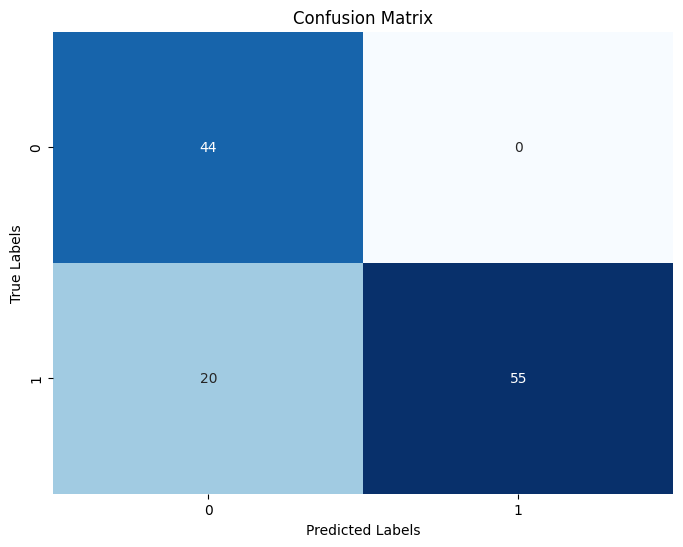



Fold 2:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 667ms/step
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

      benign       0.85      1.00      0.92        44
   malignant       1.00      0.89      0.94        75

    accuracy                           0.93       119
   macro avg       0.92      0.95      0.93       119
weighted avg       0.94      0.93      0.93       119



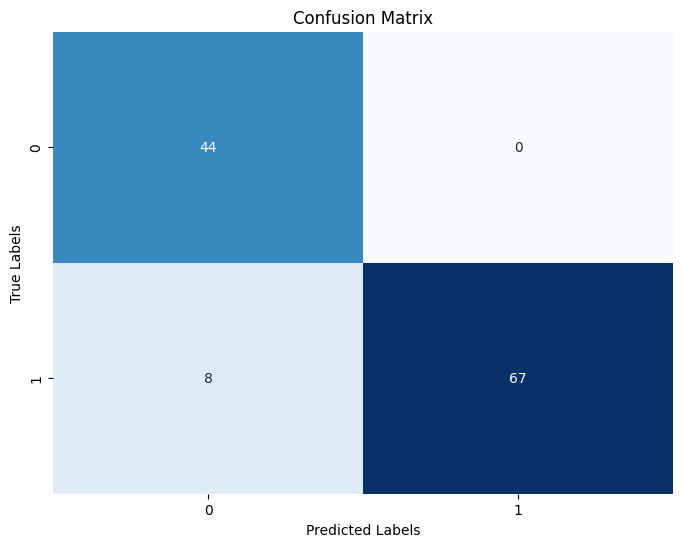



Fold 3:


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

      benign       0.83      1.00      0.91        44
   malignant       1.00      0.88      0.94        75

    accuracy                           0.92       119
   macro avg       0.92      0.94      0.92       119
weighted avg       0.94      0.92      0.93       119



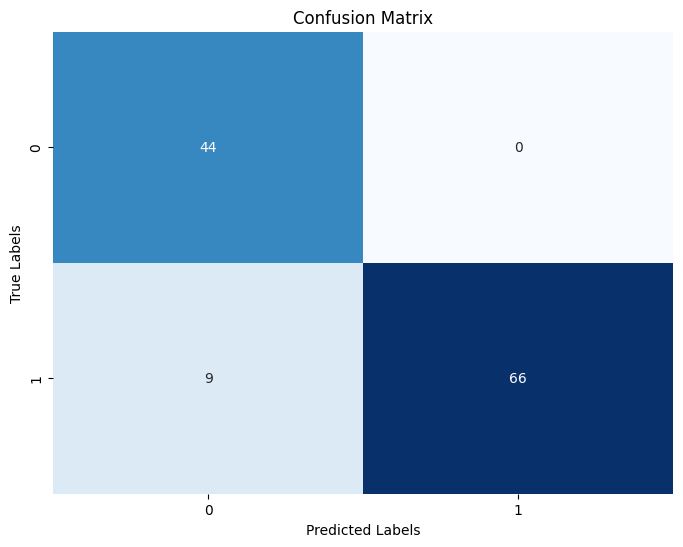



Fold 4:


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

      benign       0.77      1.00      0.87        44
   malignant       1.00      0.83      0.91        75

    accuracy                           0.89       119
   macro avg       0.89      0.91      0.89       119
weighted avg       0.92      0.89      0.89       119



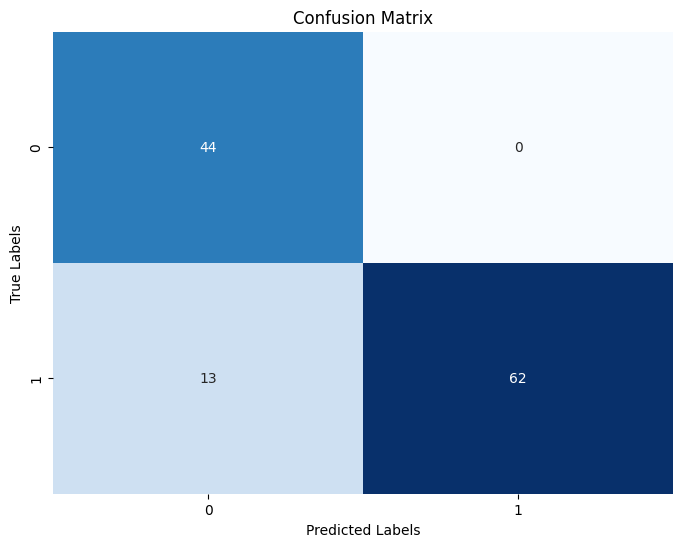



Fold 5:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

      benign       0.79      0.95      0.87        44
   malignant       0.97      0.85      0.91        75

    accuracy                           0.89       119
   macro avg       0.88      0.90      0.89       119
weighted avg       0.90      0.89      0.89       119



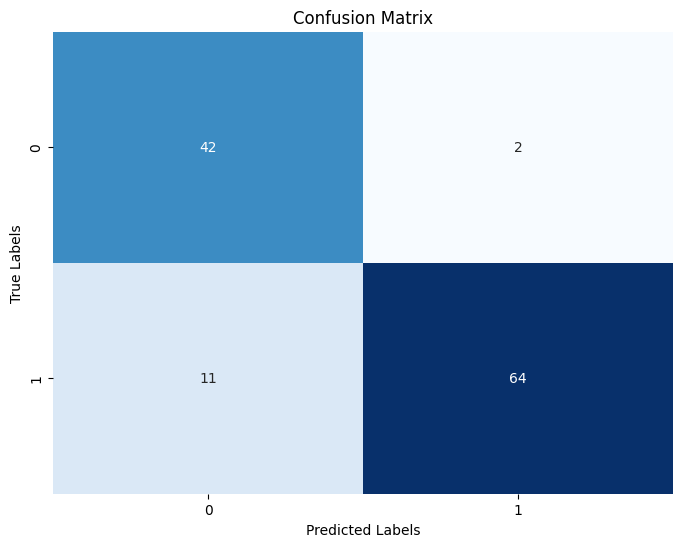



Fold 6:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 521ms/step
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

      benign       0.77      1.00      0.87        44
   malignant       1.00      0.83      0.91        75

    accuracy                           0.89       119
   macro avg       0.89      0.91      0.89       119
weighted avg       0.92      0.89      0.89       119



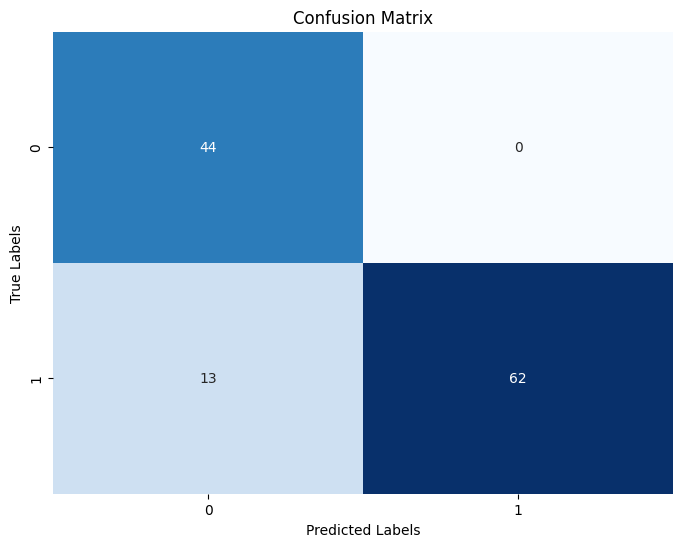



Fold 7:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

      benign       0.81      1.00      0.90        44
   malignant       1.00      0.87      0.93        75

    accuracy                           0.92       119
   macro avg       0.91      0.93      0.91       119
weighted avg       0.93      0.92      0.92       119



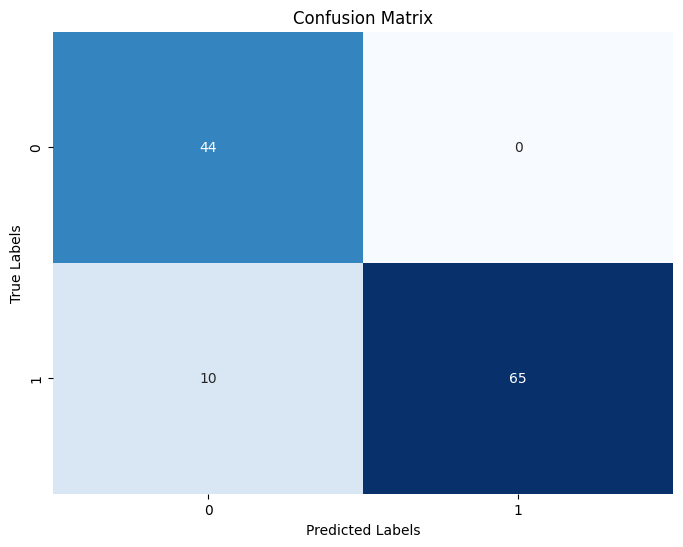



Fold 8:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

      benign       0.76      1.00      0.86        44
   malignant       1.00      0.81      0.90        75

    accuracy                           0.88       119
   macro avg       0.88      0.91      0.88       119
weighted avg       0.91      0.88      0.88       119



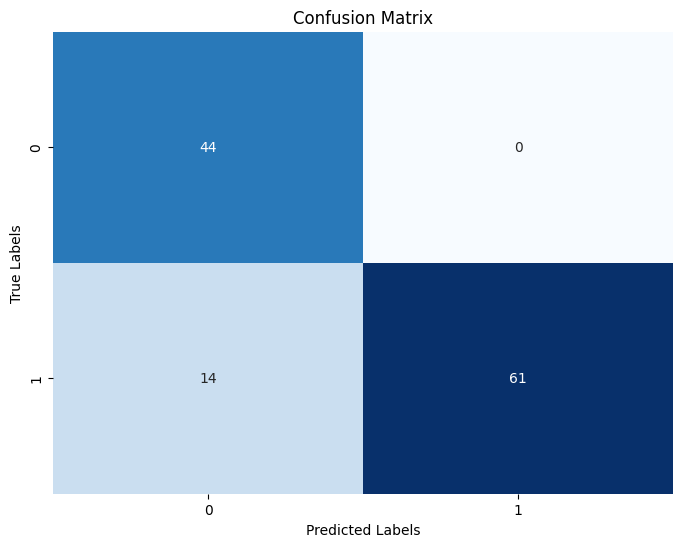



Fold 9:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

      benign       0.80      1.00      0.89        44
   malignant       1.00      0.85      0.92        75

    accuracy                           0.91       119
   macro avg       0.90      0.93      0.90       119
weighted avg       0.93      0.91      0.91       119



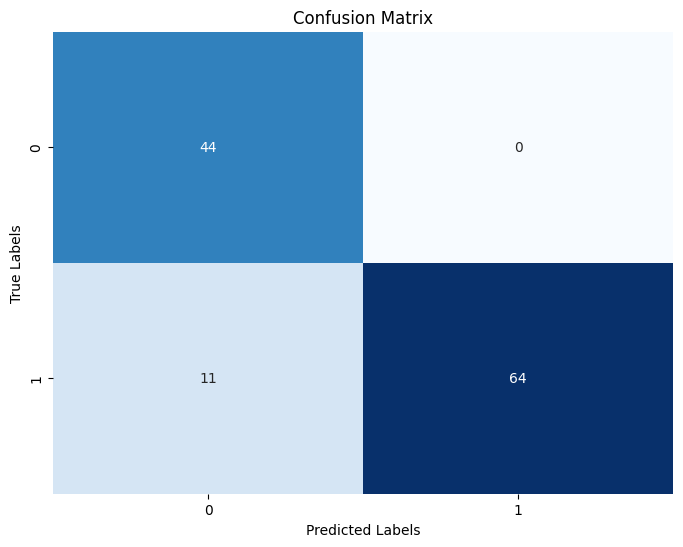



Fold 10:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

      benign       0.81      1.00      0.90        44
   malignant       1.00      0.87      0.93        75

    accuracy                           0.92       119
   macro avg       0.91      0.93      0.91       119
weighted avg       0.93      0.92      0.92       119



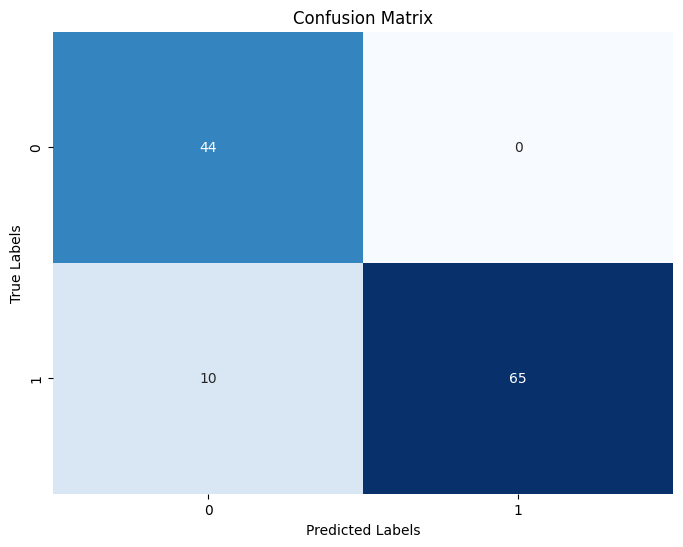

In [ ]:
evaluate_and_plot(histories_model_imagenet, test_ds)

### Plot da curva ROC

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 642ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 736ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 569ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step


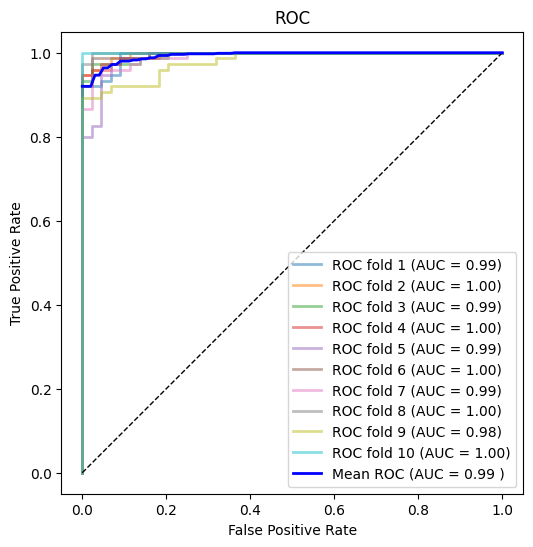

In [ ]:
plot_roc_curves(histories_model_imagenet, test_ds)

## Com Pesos BreaKHis

### Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_transfer_mode_weightsBreaKHis(weights_path):
    # Carregar modelo pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelar as camadas do modelo pré-treinado
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    try:
        model.load_weights(weights_path)  # Carregar os pesos completos
        print("Pesos treinados carregados com sucesso.")
    except Exception as e:
        print(f"Erro ao carregar os pesos: {e}")

    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    return model


### Pesos

In [ ]:
# Caminho para o arquivo .h5 com os pesos pré-treinados
weights_path = '/content/drive/MyDrive/vgg16_BreaKHis_model2.h5'

### Kfold

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 10
histories_model_weights_breakhis = []

kfold = KFold(10, shuffle=True, random_state=123)

for f, (trn_ind2, val_ind2) in enumerate(kfold.split(train_dataset)):

    print();
    print("#"*50)
    print("Fold: ",f+1)
    print("#"*50)

    training_data = train_dataset.iloc[trn_ind]
    validation_data = train_dataset.iloc[val_ind]

    train_ds2 = gerador_treinamento.flow_from_dataframe(training_data,
                                            x_col='PATH', y_col='LABELS',
                                            target_size=(width,height),
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = 32, shuffle = True)
    print(train_ds.class_indices)
    val_ds2 = gerador_treinamento.flow_from_dataframe(validation_data,
                                        x_col='PATH', y_col='LABELS',
                                        target_size=(width,height),
                                        class_mode = 'binary', color_mode = 'rgb',
                                        batch_size = 32, shuffle = False)

    model = create_transfer_mode_weightsBreaKHis(weights_path)


    # Treinar o modelo
    history2 = model.fit(
    train_ds2,
    steps_per_epoch=train_ds2.samples // batch_size,
    epochs=EPOCHS,
    validation_data=val_ds2,
    validation_steps=val_ds2.samples // batch_size
    )

    # store history pra cada folds
    histories_model_weights_breakhis.append(history2)

    clear_session()


##################################################
Fold:  1
##################################################
Found 426 validated image filenames belonging to 2 classes.
{'benign': 0, 'malignant': 1}
Found 47 validated image filenames belonging to 2 classes.
Pesos treinados carregados com sucesso.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7816 - auc_1: 0.8548 - loss: 0.4671 - precision_1: 0.8177 - recall_1: 0.8645 - val_accuracy: 0.8125 - val_auc_1: 0.9490 - val_loss: 0.3294 - val_precision_1: 0.8667 - val_recall_1: 0.7647
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8125 - auc_1: 0.8551 - loss: 0.5434 - precision_1: 0.9048 - recall_1: 0.8261

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8125 - auc_1: 0.8551 - loss: 0.5434 - precision_1: 0.9048 - recall_1: 0.8261 - val_accuracy: 0.9333 - val_auc_1: 0.9800 - val_loss: 0.1938 - val_precision_1: 0.9091 - val_recall_1: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8544 - auc_1: 0.9226 - loss: 0.3667 - precision_1: 0.8594 - recall_1: 0.9353  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9688 - auc_1: 1.0000 - loss: 0.0800 - precision_1: 1.0000 - recall_1: 0.9474 - val_accuracy: 0.9688 - val_auc_1: 1.0000 - val_loss: 0.1940 - val_precision_1: 1.0000 - val_recall_1: 0.9412
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 797ms/step - accuracy: 0.9345 - auc_1: 0.9782 - loss: 0.1874 - precision_1: 0.9490 - recall_1: 0.9457 - val_accuracy: 0.9333 - val_auc_1: 1.0000 - val_loss: 0.1040 - val_precision_1: 0.9091 - val_recall_1: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9375 - auc_1: 0.9727 - loss: 0.2577 - prec

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8100 - auc: 0.8672 - loss: 0.4459 - precision: 0.8452 - recall: 0.8783 - val_accuracy: 0.9062 - val_auc: 0.9627 - val_loss: 0.2886 - val_precision: 0.9375 - val_recall: 0.8824
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8438 - auc: 0.9336 - loss: 0.3219 - precision: 0.8235 - recall: 0.8750

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8438 - auc: 0.9336 - loss: 0.3219 - precision: 0.8235 - recall: 0.8750 - val_accuracy: 0.8000 - val_auc: 0.9600 - val_loss: 0.3294 - val_precision: 1.0000 - val_recall: 0.7000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 874ms/step - accuracy: 0.9307 - auc: 0.9726 - loss: 0.2263 - precision: 0.9800 - recall: 0.9054
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9062 - auc: 0.9583 - loss: 0.3852 - precision: 0.8696 - recall: 1.0000 - val_accuracy: 0.9062 - val_auc: 0.9843 - val_loss: 0.2601 - val_precision: 0.8500 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 952ms/step - accuracy: 0.9207 - auc: 0.9844 - loss: 0.1702 - precision: 0.9153 - recall: 0.9695 - val_accuracy: 0.8667 - val_auc: 1.0000 - val_loss: 0.1262 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.1027 - precision: 0.9048 - recall: 1.0000  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7926 - auc: 0.8680 - loss: 0.4587 - precision: 0.8274 - recall: 0.8538 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2313 - val_precision: 1.0000 - val_recall: 0.8824
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9062 - auc: 0.9625 - loss: 0.2423 - precision: 1.0000 - recall: 0.8500

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9062 - auc: 0.9625 - loss: 0.2423 - precision: 1.0000 - recall: 0.8500 - val_accuracy: 0.8667 - val_auc: 1.0000 - val_loss: 0.2135 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9200 - auc: 0.9602 - loss: 0.2439 - precision: 0.9255 - recall: 0.9505  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0502 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9375 - val_auc: 0.9922 - val_loss: 0.1959 - val_precision: 1.0000 - val_recall: 0.8824
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 827ms/step - accuracy: 0.9398 - auc: 0.9934 - loss: 0.1265 - precision: 0.9908 - recall: 0.9163 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0657 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0464 - precision: 1.0000 - recall: 1.0000 
Epoch 7/10
1

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8012 - auc: 0.8753 - loss: 0.4776 - precision: 0.8205 - recall: 0.8811 - val_accuracy: 0.8750 - val_auc: 0.9647 - val_loss: 0.3307 - val_precision: 1.0000 - val_recall: 0.7647
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9688 - auc: 0.9960 - loss: 0.1169 - precision: 1.0000 - recall: 0.9474

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9688 - auc: 0.9960 - loss: 0.1169 - precision: 1.0000 - recall: 0.9474 - val_accuracy: 0.8667 - val_auc: 1.0000 - val_loss: 0.2979 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8465 - auc: 0.9411 - loss: 0.3235 - precision: 0.8925 - recall: 0.8510
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9688 - auc: 0.9773 - loss: 0.1337 - precision: 1.0000 - recall: 0.9545 - val_accuracy: 0.9375 - val_auc: 0.9686 - val_loss: 0.2418 - val_precision: 1.0000 - val_recall: 0.8824
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 930ms/step - accuracy: 0.9460 - auc: 0.9857 - loss: 0.1469 - precision: 0.9606 - recall: 0.9518 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0530 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - auc: 1.0000 - loss: 0.3535 - precision: 0.7826 - recall: 1.0000  
Epoch 7/10
13

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7982 - auc: 0.8391 - loss: 0.5094 - precision: 0.8160 - recall: 0.8909 - val_accuracy: 0.6875 - val_auc: 0.9373 - val_loss: 0.6262 - val_precision: 0.6296 - val_recall: 1.0000
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8438 - auc: 0.9069 - loss: 0.4210 - precision: 0.7917 - recall: 1.0000

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8438 - auc: 0.9069 - loss: 0.4210 - precision: 0.7917 - recall: 1.0000 - val_accuracy: 0.8667 - val_auc: 0.9400 - val_loss: 0.3199 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step - accuracy: 0.8795 - auc: 0.9635 - loss: 0.2619 - precision: 0.9184 - recall: 0.8808
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.8750 - auc: 0.9420 - loss: 0.3361 - precision: 0.8519 - recall: 1.0000 - val_accuracy: 0.8438 - val_auc: 1.0000 - val_loss: 0.2557 - val_precision: 0.7727 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 974ms/step - accuracy: 0.8759 - auc: 0.9757 - loss: 0.2256 - precision: 0.8616 - recall: 0.9581 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0835 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.0937 - precision: 1.0000 - recall: 0.9167  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7617 - auc: 0.8334 - loss: 0.4987 - precision: 0.8016 - recall: 0.8433 - val_accuracy: 0.9375 - val_auc: 0.9412 - val_loss: 0.3274 - val_precision: 0.9412 - val_recall: 0.9412
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9062 - auc: 0.9591 - loss: 0.2860 - precision: 1.0000 - recall: 0.8636

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9062 - auc: 0.9591 - loss: 0.2860 - precision: 1.0000 - recall: 0.8636 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1256 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8596 - auc: 0.9565 - loss: 0.2552 - precision: 0.8995 - recall: 0.8862  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8125 - auc: 0.9815 - loss: 0.6750 - precision: 1.0000 - recall: 0.7778 - val_accuracy: 0.8438 - val_auc: 0.9804 - val_loss: 0.4698 - val_precision: 1.0000 - val_recall: 0.7059
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 835ms/step - accuracy: 0.9030 - auc: 0.9718 - loss: 0.2224 - precision: 0.9232 - recall: 0.9312 - val_accuracy: 0.9333 - val_auc: 1.0000 - val_loss: 0.1130 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0738 - precision: 1.0000 - recall: 0.9474  
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7697 - auc: 0.8697 - loss: 0.4818 - precision: 0.7898 - recall: 0.8547 - val_accuracy: 0.9062 - val_auc: 0.9922 - val_loss: 0.3216 - val_precision: 0.8500 - val_recall: 1.0000
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.8438 - auc: 0.9394 - loss: 0.3021 - precision: 0.8636 - recall: 0.9048

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8438 - auc: 0.9394 - loss: 0.3021 - precision: 0.8636 - recall: 0.9048 - val_accuracy: 0.9333 - val_auc: 1.0000 - val_loss: 0.2440 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8845 - auc: 0.9652 - loss: 0.2508 - precision: 0.9410 - recall: 0.8757
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0641 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9688 - val_auc: 0.9961 - val_loss: 0.1540 - val_precision: 1.0000 - val_recall: 0.9412
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 700ms/step - accuracy: 0.9320 - auc: 0.9813 - loss: 0.1764 - precision: 0.9607 - recall: 0.9319 - val_accuracy: 0.9333 - val_auc: 1.0000 - val_loss: 0.1008 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - auc: 1.0000 - loss: 0.1359 - precision: 1.0000 - recall: 0.8750  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8009 - auc: 0.8906 - loss: 0.4287 - precision: 0.8476 - recall: 0.8510 - val_accuracy: 0.9375 - val_auc: 0.9882 - val_loss: 0.2568 - val_precision: 1.0000 - val_recall: 0.8824
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9688 - auc: 0.9879 - loss: 0.1318 - precision: 1.0000 - recall: 0.9474

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9688 - auc: 0.9879 - loss: 0.1318 - precision: 1.0000 - recall: 0.9474 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1611 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9101 - auc: 0.9750 - loss: 0.2021 - precision: 0.9233 - recall: 0.9325  
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9062 - auc: 0.9417 - loss: 0.3271 - precision: 0.8696 - recall: 1.0000 - val_accuracy: 0.8438 - val_auc: 0.9922 - val_loss: 0.3053 - val_precision: 0.7727 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 787ms/step - accuracy: 0.8959 - auc: 0.9625 - loss: 0.2647 - precision: 0.9033 - recall: 0.9428 - val_accuracy: 0.8667 - val_auc: 1.0000 - val_loss: 0.1798 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 677ms/step - accuracy: 0.9375 - auc: 0.9778 - loss: 0.2542 - precision: 1.0000 - recall: 0.9259
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7396 - auc: 0.8136 - loss: 0.5615 - precision: 0.7830 - recall: 0.8103 - val_accuracy: 0.9062 - val_auc: 0.9784 - val_loss: 0.2628 - val_precision: 0.8889 - val_recall: 0.9412
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7812 - auc: 0.9683 - loss: 0.5196 - precision: 0.7200 - recall: 1.0000

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7812 - auc: 0.9683 - loss: 0.5196 - precision: 0.7200 - recall: 1.0000 - val_accuracy: 0.9333 - val_auc: 0.9800 - val_loss: 0.2210 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 915ms/step - accuracy: 0.8760 - auc: 0.9339 - loss: 0.3339 - precision: 0.9188 - recall: 0.8826
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9375 - auc: 0.9818 - loss: 0.2023 - precision: 0.9167 - recall: 1.0000 - val_accuracy: 0.9062 - val_auc: 0.9608 - val_loss: 0.2787 - val_precision: 1.0000 - val_recall: 0.8235
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 756ms/step - accuracy: 0.9176 - auc: 0.9683 - loss: 0.2140 - precision: 0.9475 - recall: 0.9279 - val_accuracy: 0.9333 - val_auc: 1.0000 - val_loss: 0.2068 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8750 - auc: 0.9500 - loss: 0.2758 - precision: 1.0000 - recall: 0.8000  
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7796 - auc: 0.8521 - loss: 0.4850 - precision: 0.8146 - recall: 0.8401 - val_accuracy: 0.7188 - val_auc: 0.9431 - val_loss: 0.3794 - val_precision: 0.6667 - val_recall: 0.9412
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8125 - auc: 0.9417 - loss: 0.3645 - precision: 0.7917 - recall: 0.9500

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8125 - auc: 0.9417 - loss: 0.3645 - precision: 0.7917 - recall: 0.9500 - val_accuracy: 0.8000 - val_auc: 0.9400 - val_loss: 0.2986 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 946ms/step - accuracy: 0.8432 - auc: 0.9517 - loss: 0.3198 - precision: 0.8340 - recall: 0.9507
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8438 - auc: 0.9608 - loss: 0.2299 - precision: 0.7778 - recall: 0.9333 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1677 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 867ms/step - accuracy: 0.9583 - auc: 0.9901 - loss: 0.1195 - precision: 0.9666 - recall: 0.9682 - val_accuracy: 0.9333 - val_auc: 1.0000 - val_loss: 0.1021 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.1320 - precision: 0.9500 - recall: 1.0000  
Epoch 7/10

### Métricas de cada FOLD

Fold 1:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step
Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

      benign       0.79      1.00      0.88        44
   malignant       1.00      0.84      0.91        75

    accuracy                           0.90       119
   macro avg       0.89      0.92      0.90       119
weighted avg       0.92      0.90      0.90       119



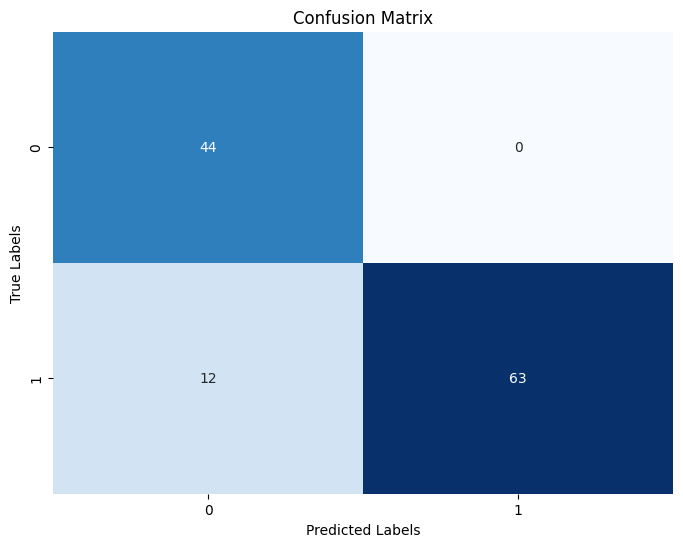



Fold 2:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 729ms/step
Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

      benign       0.79      1.00      0.88        44
   malignant       1.00      0.84      0.91        75

    accuracy                           0.90       119
   macro avg       0.89      0.92      0.90       119
weighted avg       0.92      0.90      0.90       119



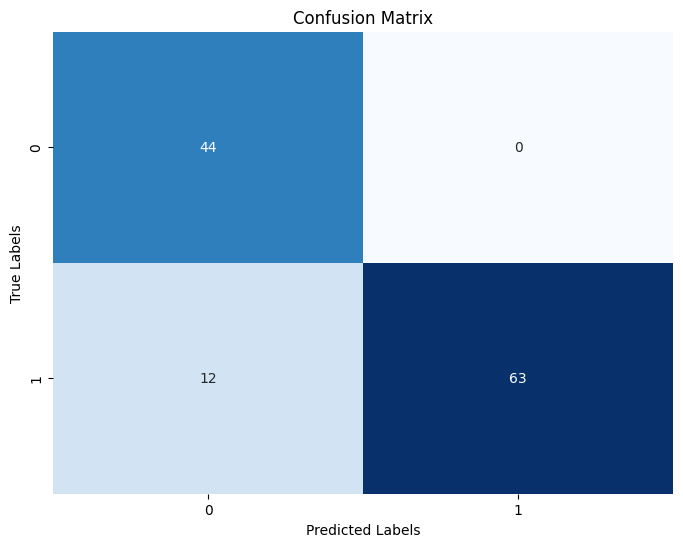



Fold 3:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

      benign       0.91      0.98      0.95        44
   malignant       0.99      0.95      0.97        75

    accuracy                           0.96       119
   macro avg       0.95      0.96      0.96       119
weighted avg       0.96      0.96      0.96       119



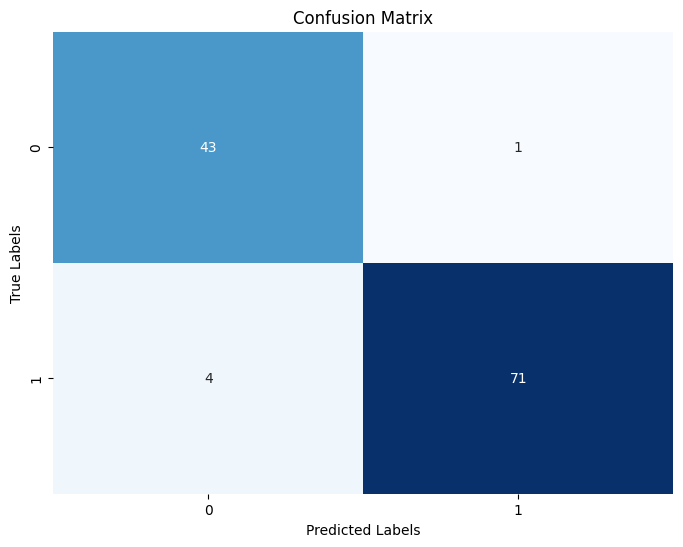



Fold 4:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 714ms/step
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

      benign       0.85      1.00      0.92        44
   malignant       1.00      0.89      0.94        75

    accuracy                           0.93       119
   macro avg       0.92      0.95      0.93       119
weighted avg       0.94      0.93      0.93       119



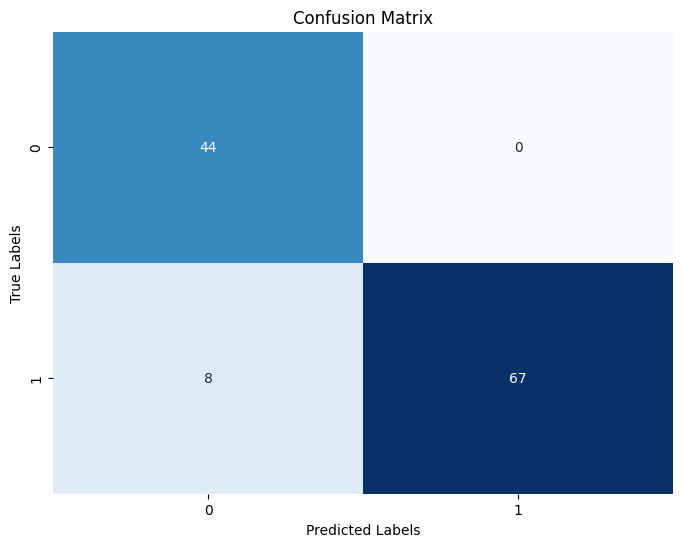



Fold 5:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

      benign       0.90      1.00      0.95        44
   malignant       1.00      0.93      0.97        75

    accuracy                           0.96       119
   macro avg       0.95      0.97      0.96       119
weighted avg       0.96      0.96      0.96       119



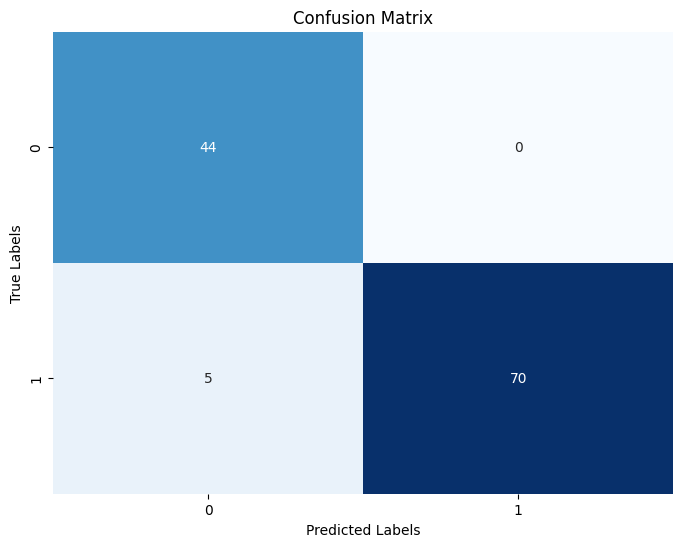



Fold 6:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 743ms/step
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

      benign       0.88      1.00      0.94        44
   malignant       1.00      0.92      0.96        75

    accuracy                           0.95       119
   macro avg       0.94      0.96      0.95       119
weighted avg       0.96      0.95      0.95       119



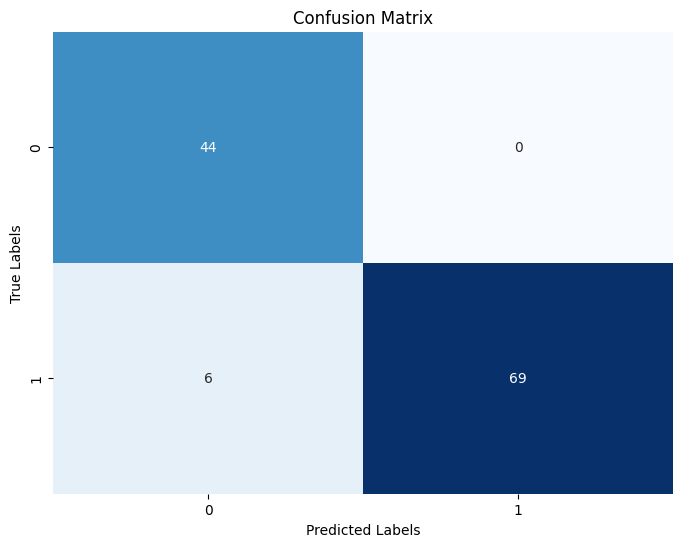



Fold 7:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 526ms/step
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

      benign       0.86      1.00      0.93        44
   malignant       1.00      0.91      0.95        75

    accuracy                           0.94       119
   macro avg       0.93      0.95      0.94       119
weighted avg       0.95      0.94      0.94       119



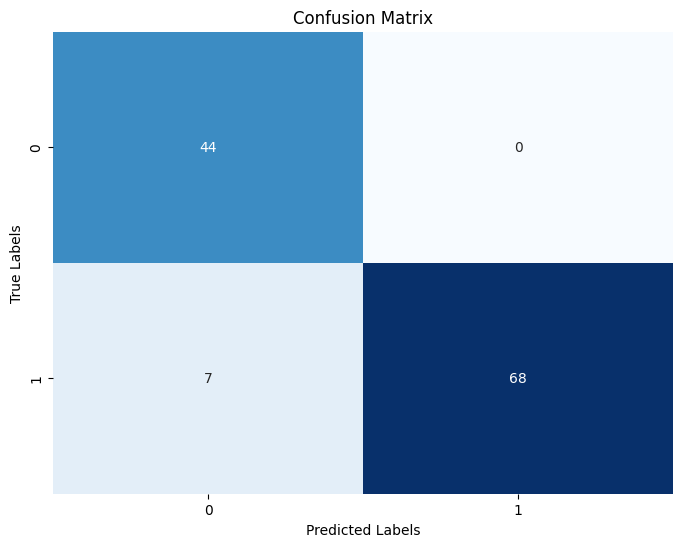



Fold 8:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 733ms/step
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

      benign       0.85      1.00      0.92        44
   malignant       1.00      0.89      0.94        75

    accuracy                           0.93       119
   macro avg       0.92      0.95      0.93       119
weighted avg       0.94      0.93      0.93       119



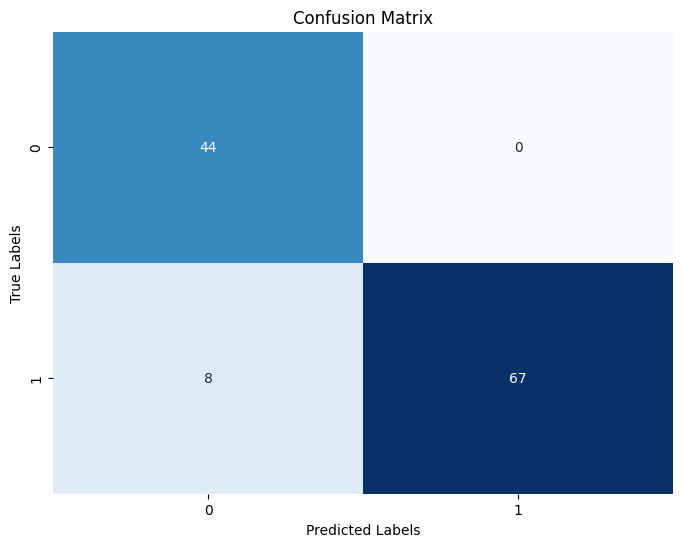



Fold 9:
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

      benign       0.88      1.00      0.94        44
   malignant       1.00      0.92      0.96        75

    accuracy                           0.95       119
   macro avg       0.94      0.96      0.95       119
weighted avg       0.96      0.95      0.95       119



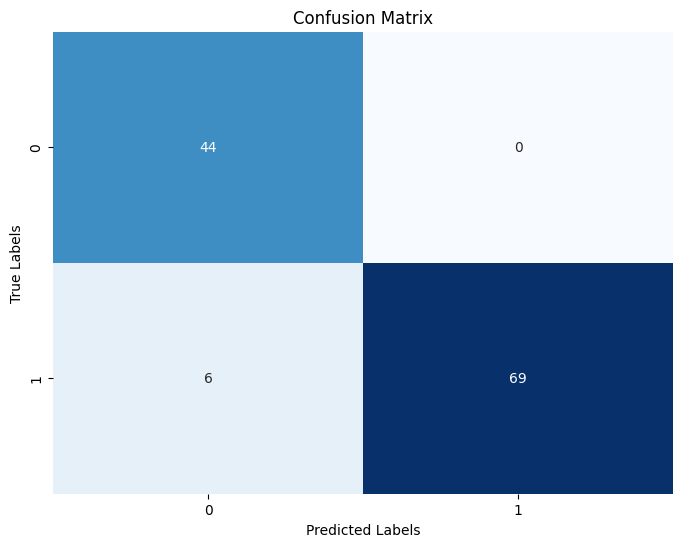



Fold 10:
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 703ms/step
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

      benign       0.90      1.00      0.95        44
   malignant       1.00      0.93      0.97        75

    accuracy                           0.96       119
   macro avg       0.95      0.97      0.96       119
weighted avg       0.96      0.96      0.96       119



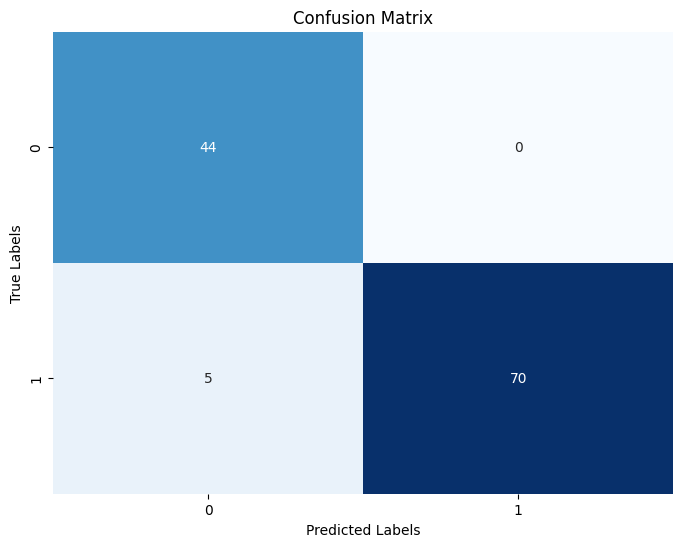

In [ ]:
evaluate_and_plot(histories_model_weights_breakhis, test_ds)

### Plot da curva ROC


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 673ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step


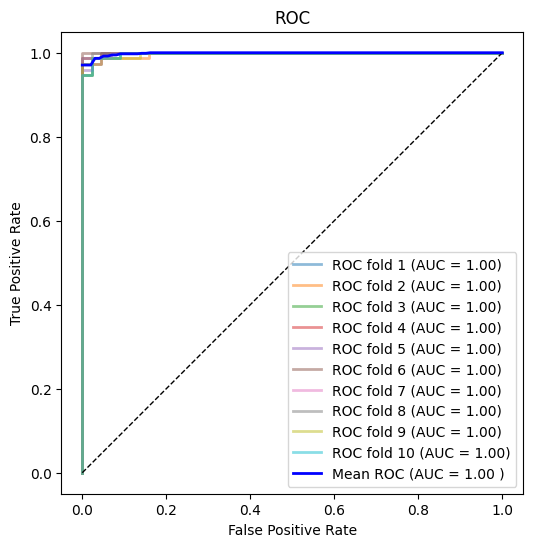

In [ ]:
plot_roc_curves(histories_model_weights_breakhis, test_ds)

## Comparação dos dois resultados em Curva ROC

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 737ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 590ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 723ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 794ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 598ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 738ms/step


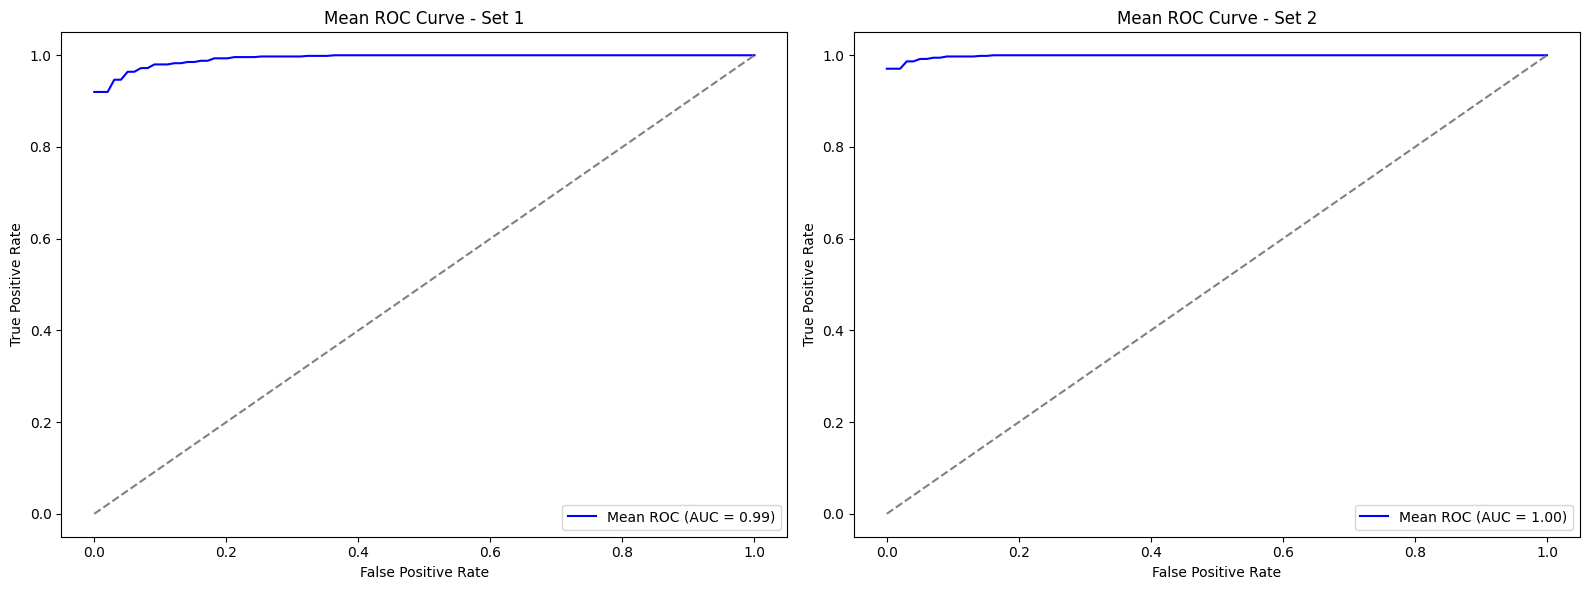

In [ ]:
def plot_mean_roc_media(histories_list, test_ds):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for i, histories in enumerate(histories_list):
        mean_fpr = np.linspace(0, 1, 100)
        tpr_sum = np.zeros(100)

        for history in histories:

            test_predictions = history.model.predict(test_ds)

            fpr, tpr, _ = roc_curve(test_ds.labels, test_predictions)
            tpr_sum += np.interp(mean_fpr, fpr, tpr)

        mean_tpr = tpr_sum / len(histories)

        mean_auc = auc(mean_fpr, mean_tpr)

        # Plotar a curva ROC média
        ax = axes[i]
        ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Mean ROC Curve - Set {i+1}')
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


plot_mean_roc_media([histories_model_imagenet, histories_model_weights_breakhis], test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 518ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 625ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 697ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 808ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 754ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 735ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 618ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step


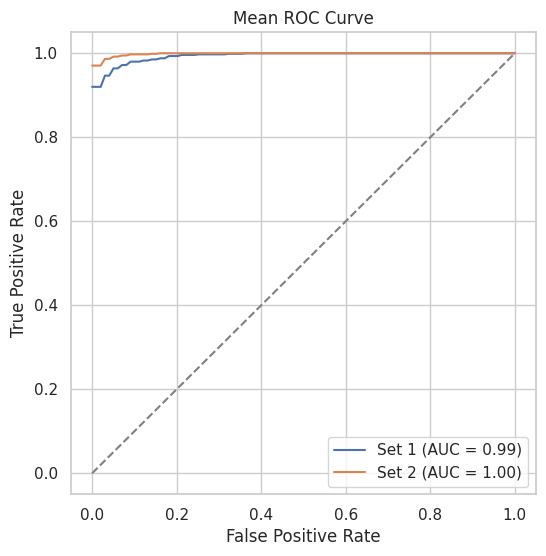

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_mean_roc_media(histories_list, test_ds):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))

    for i, histories in enumerate(histories_list):
        mean_fpr = np.linspace(0, 1, 100)
        tpr_sum = np.zeros(100)

        for history in histories:
            test_predictions = history.model.predict(test_ds)
            fpr, tpr, _ = roc_curve(test_ds.labels, test_predictions)
            tpr_sum += np.interp(mean_fpr, fpr, tpr)

        mean_tpr = tpr_sum / len(histories)
        mean_auc = auc(mean_fpr, mean_tpr)

        plt.plot(mean_fpr, mean_tpr, label=f'Set {i+1} (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend()
    plt.show()

# Chama a função para plotar as curvas ROC médias
plot_mean_roc_media([histories_model_imagenet, histories_model_weights_breakhis], test_ds)


In [ ]:
from sklearn.metrics import accuracy_score

def calculate_average_accuracy(histories, test_ds):
    fold_accuracies = []

    for fold, history in enumerate(histories, start=1):
        # Prever as classes no conjunto de teste
        test_predictions = history.model.predict(test_ds)
        test_predictions_binary = (test_predictions > 0.5).astype(int)

        y_test = test_ds.labels

        accuracy = accuracy_score(y_test, test_predictions_binary)

        fold_accuracies.append(accuracy)

    avg_accuracy = np.mean(fold_accuracies)
    return avg_accuracy
accuracy_model1 = calculate_average_accuracy(histories_model_imagenet, test_ds)
accuracy_model2 = calculate_average_accuracy(histories_model_weights_breakhis, test_ds)
print('Sem pesos BreakHis:')
print(f"Accuracy: {accuracy_model1:.2f}")
print('Com pesos BreakHis:')
print(f"Accuracy: {accuracy_model2:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 552ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 740ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 745ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 625ms/step
Sem pesos BreakHis:
Accuracy: 0.90
Com pesos BreakHis:
Accuracy: 0.94


In [ ]:
from scipy.stats import kruskal, shapiro
from sklearn.metrics import roc_auc_score

def collect_metrics(histories, test_ds):
    """
    Coleta as métricas de AUC para cada modelo em um conjunto de históricos.

    Args:
        histories (list): Lista de históricos (com modelos).
        test_ds (tf.data.Dataset): Conjunto de teste.

    Returns:
        list: Lista de métricas AUC para os modelos fornecidos.
    """
    auc_scores = []

    for history in histories:
        # Fazer predições
        test_predictions = history.model.predict(test_ds)

        # Calcular AUC
        auc = roc_auc_score(test_ds.labels, test_predictions)
        auc_scores.append(auc)

    return auc_scores

# Coletar métricas de AUC para os dois grupos
auc_imagenet = collect_metrics(histories_model_imagenet, test_ds)
auc_breakhis = collect_metrics(histories_model_weights_breakhis, test_ds)

# Testar a normalidade dos dados (Shapiro-Wilk)
stat_imagenet, p_imagenet = shapiro(auc_imagenet)
stat_breakhis, p_breakhis = shapiro(auc_breakhis)

print(f"Normalidade ImageNet: estatística={stat_imagenet}, p={p_imagenet}")
print(f"Normalidade BreakHis: estatística={stat_breakhis}, p={p_breakhis}")
# Inicializar p_value como None
p_value = None

# Aplicar Kruskal-Wallis se os dados não forem normais
if p_imagenet < 0.05 or p_breakhis < 0.05:
    stat, p_value = kruskal(auc_imagenet, auc_breakhis)
    print(f"Teste Kruskal-Wallis: estatística={stat}, p={p_value}")
else:
    print("Os dados são normais. Considere usar ANOVA para comparar os grupos.")

# Interpretação
if p_value is not None and p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos.")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 634ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 756ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 653ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 524ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 741ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step
Normalidade ImageNet: estatística=0.8705126241762078, p=0.10135013602917198
Normalidade BreakHis: estatística=0.9575532147748405, p=0.7576537305686641
Os dados são normais. Considere usar ANOVA para comparar os grupos.
N

## Teste com Breakhis model

Pesos treinados carregados com sucesso.
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        44
         1.0       0.63      0.99      0.77        75

    accuracy                           0.62       119
   macro avg       0.31      0.49      0.38       119
weighted avg       0.40      0.62      0.48       119



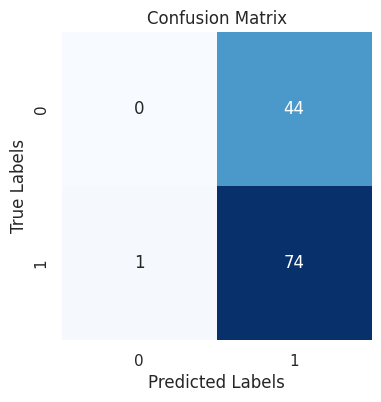

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Carregar o modelo (assumindo que você já tenha a função `create_transfer_mode_weightsBreaKHis`)
model3 = create_transfer_mode_weightsBreaKHis(weights_path)

# Carregar os pesos no modelo
model3.load_weights(weights_path)

# Fazer as predições no conjunto de teste
test_predictions = model3.predict(test_ds, verbose=0)

# Arredondar as previsões para classes binárias (0 ou 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Extrair os rótulos reais do conjunto de teste
true_labels = []
for x, y in test_ds:
    true_labels.append(y)
    # Parar após completar todos os lotes
    if len(true_labels) * test_ds.batch_size >= len(test_ds.filenames):
        break

# Concatenar os rótulos reais em um único array
y_test = np.concatenate(true_labels, axis=0)

# Imprimir o Classification Report
report = classification_report(y_test, test_predictions_binary)
print("Classification Report:\n", report)

# Calcular a matriz de confusão
confusion = confusion_matrix(y_test, test_predictions_binary)

# Plotar a matriz de confusão usando seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 730ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 518ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 748ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 751ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 723ms/step


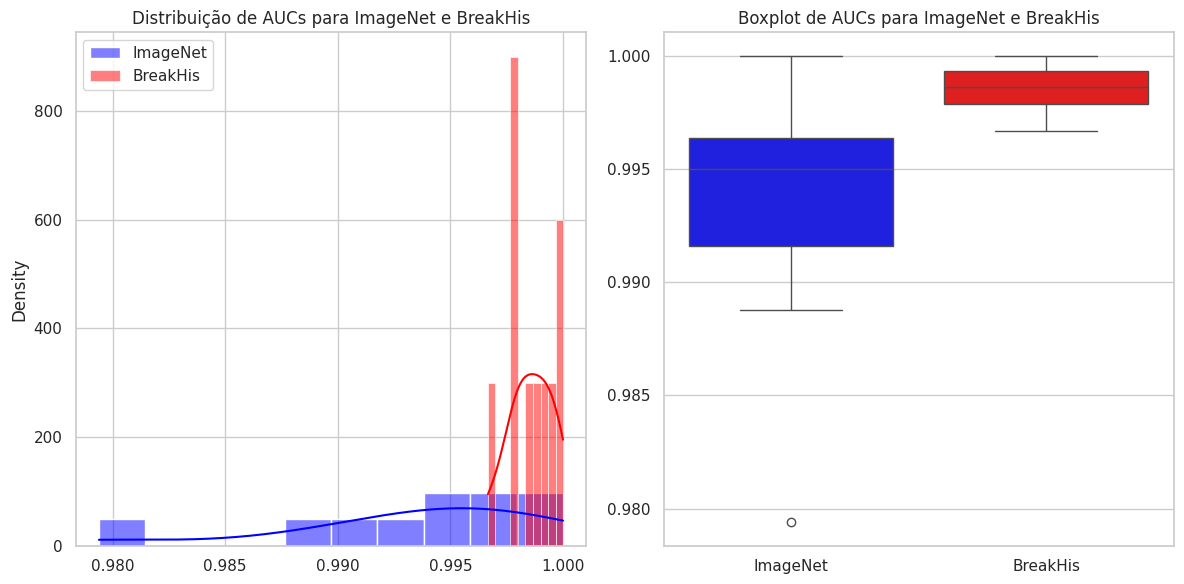

Normalidade ImageNet: estatística=0.8705126241762078, p=0.10135013602917198
Normalidade BreakHis: estatística=0.9575532147748405, p=0.7576537305686641
Teste de Levene (Homogeneidade de Variância): estatística=4.901318340441986, p=0.03998491409835323
Os dados são normais. Considere usar ANOVA para comparar os grupos.
Não há diferença estatisticamente significativa entre os grupos.


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import kruskal, shapiro, levene

def collect_metrics(histories, test_ds):
    """
    Coleta as métricas de AUC para cada modelo em um conjunto de históricos.
    """
    auc_scores = []

    for history in histories:
        # Fazer predições
        test_predictions = history.model.predict(test_ds)

        # Calcular AUC
        auc = roc_auc_score(test_ds.labels, test_predictions)
        auc_scores.append(auc)

    return auc_scores

def plot_distributions(auc_imagenet, auc_breakhis):
    """
    Plota a distribuição dos AUCs para ImageNet e BreakHis.
    """
    plt.figure(figsize=(12, 6))

    # Histogramas
    plt.subplot(1, 2, 1)
    sns.histplot(auc_imagenet, kde=True, color="blue", label="ImageNet", stat="density", bins=10)
    sns.histplot(auc_breakhis, kde=True, color="red", label="BreakHis", stat="density", bins=10)
    plt.legend()
    plt.title("Distribuição de AUCs para ImageNet e BreakHis")

    # Boxplots
    plt.subplot(1, 2, 2)
    sns.boxplot(data=[auc_imagenet, auc_breakhis], palette=["blue", "red"])
    plt.xticks([0, 1], ["ImageNet", "BreakHis"])
    plt.title("Boxplot de AUCs para ImageNet e BreakHis")

    plt.tight_layout()
    plt.show()

# Coletar métricas de AUC para os dois grupos
auc_imagenet = collect_metrics(histories_model_imagenet, test_ds)
auc_breakhis = collect_metrics(histories_model_weights_breakhis, test_ds)

# Visualizar distribuições
plot_distributions(auc_imagenet, auc_breakhis)

# Testar a normalidade dos dados (Shapiro-Wilk)
stat_imagenet, p_imagenet = shapiro(auc_imagenet)
stat_breakhis, p_breakhis = shapiro(auc_breakhis)

print(f"Normalidade ImageNet: estatística={stat_imagenet}, p={p_imagenet}")
print(f"Normalidade BreakHis: estatística={stat_breakhis}, p={p_breakhis}")

# Testar a homogeneidade de variância (Levene)
stat_levene, p_levene = levene(auc_imagenet, auc_breakhis)
print(f"Teste de Levene (Homogeneidade de Variância): estatística={stat_levene}, p={p_levene}")

# Inicializar p_value como None
p_value = None

# Aplicar Kruskal-Wallis se os dados não forem normais
if p_imagenet < 0.05 or p_breakhis < 0.05:
    stat, p_value = kruskal(auc_imagenet, auc_breakhis)
    print(f"Teste Kruskal-Wallis: estatística={stat}, p={p_value}")
else:
    print("Os dados são normais. Considere usar ANOVA para comparar os grupos.")

# Interpretação
if p_value is not None and p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos.")


In [ ]:
from scipy.stats import f_oneway, levene
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import pandas as pd

# Supondo que auc_imagenet e auc_breakhis sejam suas listas de AUCs para cada grupo
# Combine os dados em um DataFrame
data = pd.DataFrame({
    'AUC': auc_imagenet + auc_breakhis,
    'Grupo': ['ImageNet'] * len(auc_imagenet) + ['BreakHis'] * len(auc_breakhis)
})

# Realizar Welch's ANOVA (ANOVA robusta)
model = ols('AUC ~ C(Grupo)', data=data).fit()
anova_results = anova_lm(model, typ=2)  # ANOVA de tipo 2 (modelo de efeitos principais)

print(anova_results)


            sum_sq    df         F    PR(>F)
C(Grupo)  0.000130   1.0  6.950583  0.016764
Residual  0.000336  18.0       NaN       NaN


In [ ]:
def collect_metrics(histories, test_ds):
    """
    Coleta as métricas de AUC para cada modelo em um conjunto de históricos.
    """
    auc_scores = []

    for history in histories:
        # Fazer predições
        test_predictions = history.model.predict(test_ds)

        # Calcular AUC
        auc = roc_auc_score(test_ds.labels, test_predictions)
        auc_scores.append(auc)

    return auc_scores
def perform_kruskal_wallis_test(auc_group1, auc_group2):
    """
    Realiza o Teste de Kruskal-Wallis para comparar dois grupos.
    """
    # Aplicar Kruskal-Wallis se os dados não forem normais
    stat, p_value = kruskal(auc_group1, auc_group2)

    return stat, p_value

# Coletar métricas de AUC para os dois grupos
auc_imagenet = collect_metrics(histories_model_imagenet, test_ds)
auc_breakhis = collect_metrics(histories_model_weights_breakhis, test_ds)

# Realizar o Teste de Kruskal-Wallis para comparar os dois grupos
stat, p_value = perform_kruskal_wallis_test(auc_imagenet, auc_breakhis)

# Exibir os resultados
print(f"Teste de Kruskal-Wallis: estatística={stat}, p-valor={p_value}")

# Interpretação do Teste de Kruskal-Wallis
if p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos.")
else:
    print("Não há diferença estatisticamente significativa entre os grupos.")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 524ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 603ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 745ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 649ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 732ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 537ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step
Teste de Kruskal-Wallis: estatística=6.255782312925179, p-valor=0.012378856908436008
Há uma diferença estatisticamente significativa entre os grupos.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_auc_comparison(auc_group1, auc_group2, group_names):
    """
    Plota um gráfico de boxplot comparando os AUCs de dois grupos.
    """
    # Combinando os AUCs dos dois grupos em um único array
    auc_data = [auc_group1, auc_group2]

    # Plotando o boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=auc_data, width=0.5)

    # Adicionando rótulos e título
    plt.xticks([0, 1], group_names)
    plt.ylabel('AUC Score')
    plt.title('Comparação de AUC entre os Grupos')

    # Exibindo o gráfico
    plt.show()


In [ ]:
# Coletar métricas de AUC para os dois grupos
auc_imagenet = collect_metrics(histories_model_imagenet, test_ds)
auc_breakhis = collect_metrics(histories_model_weights_breakhis, test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 527ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 573ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 706ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 661ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 743ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 728ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step


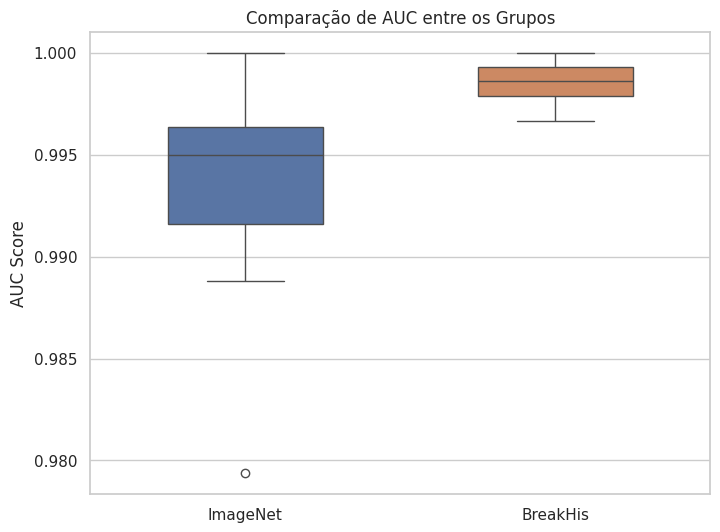

In [ ]:
# Plotando a comparação dos AUCs
plot_auc_comparison(auc_imagenet, auc_breakhis, ['ImageNet', 'BreakHis'])
